### Using the restricted three-body problem to model the interactions between a galaxy and a point-mass perturber

In [1]:
import numpy as np
import matplotlib.pyplot as plt
G = 1   #here we use normalised units for the gravitational constant, mass, distance and time

In [19]:
def accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True):   

    '''
    Function for finding the cartesian acceleration of a star in a galaxy, when feeling a force from the galaxy
    centre of mass and a point perturber.

    Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        e (float): the softening constant
        x_dir (bool): if True, calculates the acceleration in x direction, otherwise calculates the acceleration in the y direction

    Returns:
        acceleration (float): the magnitude of the acceleration in either the x or y direction    
    '''

    D_C = np.sqrt((x-x_c)**2+(y-y_c)**2+e**2)  
    D_P = np.sqrt((x-x_p)**2 + (y-y_p)**2+e**2) 
    
    if x_dir:
        acceleration = -G*M*(x-x_c)/D_C**3 
        if m_p!=0:
            acceleration -= G*m_p*(x-x_p)/D_P**3
    else:
        acceleration = -G*M*(y-y_c)/D_C**3
        if m_p!=0:
            acceleration -= G*m_p*(y-y_p)/D_P**3
    return acceleration

def taylor_one_step(x,y,x_c, y_c, x_p, y_p, v_x, v_y, M, m_p, a, e):

    '''
    Uses the taylor expansion method to find the new position and speed of a star at each time-step

     Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        v_x (float): x component of the star velocity
        v_y (float): y component of the star velocity
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
    
    Returns:
        x_new (float): updated x coordinate of the star
        y_new (float): updated y coordinate of the star
        v_x_new (float): updated x component of the star velocity
        v_y_new (float): updated y component of the star velocity
    '''
        
    x_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)

    x_new = x+a*v_x + (a**2/2)*x_accel
    y_new = y+a*v_y + (a**2/2)*y_accel

    v_x_new = v_x + a*x_accel    
    v_y_new = v_y + a*y_accel

    return x_new,y_new,v_x_new, v_y_new

def leapfrog_one_step(x,y,x_c, y_c, x_p, y_p, v_x, v_y, M, m_p, a, e):

    '''
    Uses the leapfrog method of integration to find the new position and speed of a star at each 
    time-step

     Args:
        x (float): x coordinate of the star
        y (float): y coordinate of the star
        x_c (float): x coordinate of the galaxy centre of mass
        y_c (float): y coordinate of the galaxy centre of mass
        x_p (float): x coordinate of the point perturber
        y_p (float): y coordinate of the point perturber
        v_x (float): x component of the star velocity
        v_y (float): y component of the star velocity
        M (float): mass of the galaxy
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
    
    Returns:
        x_new (float): updated x coordinate of the star
        y_new (float): updated y coordinate of the star
        v_x_new (float): updated x component of the star velocity
        v_y_new (float): updated y component of the star velocity
    '''

    x_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel = accel(x,y,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)

    x_new = x + a*v_x + 0.5*a**2*x_accel
    y_new = y + a*v_y + 0.5*a**2*y_accel

    x_accel_new = accel(x_new,y_new,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = True)
    y_accel_new = accel(x_new,y_new,x_c, y_c, x_p, y_p,M, m_p, e, x_dir = False)
    
    v_x_new = v_x + 0.5*a*(x_accel + x_accel_new)
    v_y_new = v_y + 0.5*a*(y_accel + y_accel_new)

    return x_new,y_new,v_x_new, v_y_new

def all_stars(x,y,v_x, v_y, v_p, m,m_p,a, e, n, initial, r_max, leapfrog = True):
    
    '''
    At each time-step calculates the new coordinates and velocities of each star using the function 
    taylor_one_step, then recalculates the position of the barycentre of the galaxy. Assumes the 
    perturber moves diagonally, feeling no force from the galaxy, and the galaxy is initially stationary.
    Uses either the Taylor or Leapfrog method of integration. 

    Args:
        x (array): starting x coordinate of the stars
        y (array): starting y coordinate of the stars
        v_x (array): starting x component of the stars's velocities
        v_y (array): starting y component of the stars's velocities
        v_p (float): velocity of the perturber
        m (array): masses of the stars
        m_p (float): mass of the point perturber
        a (float): time-step
        e (float): the softening constant
        n (int): number of time-steps
        initial (array): starting [x,y] position of the point perturber
        r_max (float): radius of the galaxy
        leapfrog (bool): if True, uses the leapfrog method, else uses the Taylor expansion method
    
    Returns:
        positions_array (array): array containing the [x,y] positions of each star at each time-step
        perturber_positions (array): array containing the [x,y] position of the perturber at each time-step
        barycentre (array): array containing the [x,y] position of the galaxy barycentre at each time-step
    '''

    #to store the data we create an array, with a row for each time step.
    positions_array = np.zeros((n, len(x), 2))
    perturber_positions = []
    barycentre = []
    M = np.sum(m)

    x_c = 0
    y_c = 0    #galaxy is initially centered at origin

    #Iterate over each time-step
    for i in range(n):

        barycentre.append([x_c, y_c])

        #Calculate the perturber position
        x_p = initial[0] + v_p*i*a
        y_p = initial[1] + v_p*i*a
        perturber_positions.append([x_p,y_p])

        #Iterate over each star
        for j in range(len(x)):
            if leapfrog == True:
                x_new,y_new, v_x_new, v_y_new = leapfrog_one_step(x[j],y[j],x_c, y_c, x_p, y_p, v_x[j], v_y[j], M, m_p, a, e)
            else:
                x_new,y_new, v_x_new, v_y_new = taylor_one_step(x[j],y[j],x_c, y_c, x_p, y_p, v_x[j], v_y[j], M, m_p, a, e)

            #Replace the last known position and velocity of each star with the recalculated values
            x[j] = x_new
            y[j] = y_new
            v_x[j] = v_x_new
            v_y[j] = v_y_new
            
            #Add the positions to the star array
            positions_array[i,j,0] = x_new
            positions_array[i,j,1] = y_new
        
        #Calculate the new barycentre of the galaxy. If a star is by than twice the radius of the galaxy away from the barycentre, consider that star 'stripped' and exclude it from later barycentre calculations
        x_c = 0
        y_c = 0
        m_c = 0
        for j in range(len(x)):
            if np.sqrt(x[j]**2+y[j]**2) <= r_max:
                x_c += x[j]*m[j]
                y_c += y[j]*m[j]
                m_c += m[j]
        x_c = x_c/m_c
        y_c = y_c/m_c
            
    return positions_array, np.array(perturber_positions), np.array(barycentre)

def initialise_values(p, r_max):

    '''
    Given certain parameters of a galaxy, returns the initial conditions of the stars. 

    Args:
        p (int): number of stars
        r_max (float): radius of the galaxy

    Returns:
        x (array): starting x coordinate of the stars
        y (array): starting y coordinate of the stars
        v_x (array): starting x component of the stars's velocities
        v_y (array): starting y component of the stars's velocities
        m (array): masses of the stars 
        e (float): the softening constant
        T_min (array): the shortest orbital period of stars in the galaxy
        T_max (array): the longest orbital period of stars in the galaxy
        v_min (float): the speed of the slowest star in the galaxy
    '''
    #distribute r values according to the exponential progile
    R_d = r_max/3   #set scale length to be a third of the radius
    u = np.random.rand(p)
    r = -R_d * np.log(1 - u * (1 - np.exp(-r_max/R_d)))
    
    m = [1 for _ in range(p)]   #set all masses to be equal
    e = max(r)/np.sqrt(p)     #set e relative to the size of the galaxy and number of stars

    print('Softening constant e = ', e)
    
    v = np.sqrt(G*np.sum(m)/r)

    v_min = min(v)
    T_max = 2*np.pi*max(r)/min(v) 
    T_min = 2*np.pi*min(r)/max(v) 

    print('Shorted and longest orbital periods are ', T_min, T_max)

    theta = np.random.uniform(0, 2*np.pi, p)

    x =[r[j]*np.cos(theta[j]) for j in range(len(r))]
    y =[r[j]*np.sin(theta[j]) for j in range(len(r))]
    v_x = [v[j]*np.sin(theta[j]) for j in range(len(r))]   #set speeds so that perturber and star motion is prograde
    v_y = [-v[j]*np.cos(theta[j]) for j in range(len(r))]

    return x,y, v_x, v_y, m, e, T_min, T_max, v_min

def plotting(stars, perturber, barycentre, n,c,b):

    '''
    Creates dot plots of the galaxies to show the effect of the encounter

    Args:
        stars (array): the x and y coordinates of each star at each time-step
        perturber (array): the x and y coordinates of the point perturber at each time-step
        barycentre (array): the x and y coordinates of the barycentre of the galaxy at each time-step
        n (int): the number of time-steps in the simulation
        c (int): the number of dot plots shown, equally spaced in time
        b (float): the spatial extent of the graph, centered around the galaxy centre of mass

    Returns:
        prints dot plots 
    '''

    for i in range(c):
        
        j = int(i*n/c)
        plt.figure(figsize = (5,5))

        x_com = barycentre[j,0]
        y_com = barycentre[j,1]

        plt.scatter(stars[j,:,0],stars[j,:,1], marker = 'o', s = 9, color = 'black')
        plt.scatter(perturber[j,0], perturber[j,1], color = 'red', label = 'Perturber position')
        plt.scatter(x_com, y_com, color = 'green', label = 'Barycentre')

        #centre around the barycentre for each simulation
        plt.xlim(-b/2+x_com,b/2+x_com)
        plt.ylim(-b/2+y_com,b/2+y_com)

        plt.legend(loc = "upper left")
        plt.show()

##### Set up the simulation

We will demonstrate how changing the mass, speed, and initial position of the perturber affects the resulting tidal tail of the galaxy

In [32]:
p = 1000      #number of stars
r_max = 5     #radius of galaxy
n = 20000     #number of time-steps

#find the initial coordinates, positions, masses and periods of the stars
x,y,v_x, v_y, m,e, T_min, T_max, v_min = initialise_values(p, r_max)

Softening constant e =  0.1580008516406145
Shorted and longest orbital periods are  3.745208614200978e-06 2.219059821597097


Time scale of simulation is  6.7421514023789415
Time step is  0.00033710757011894707


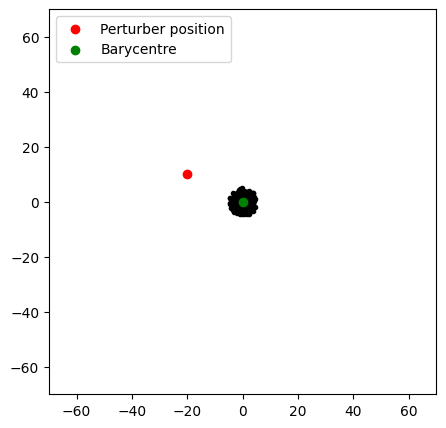

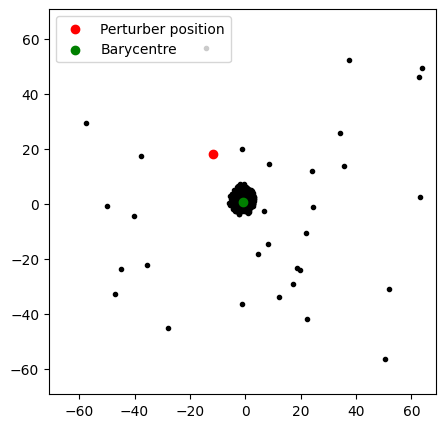

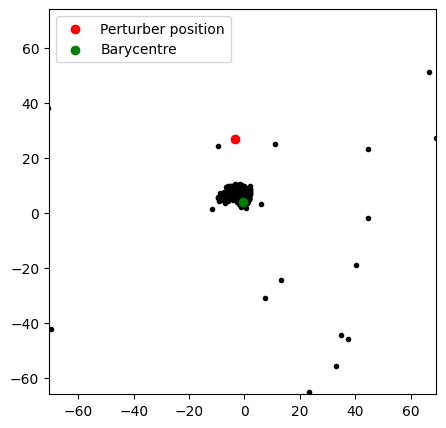

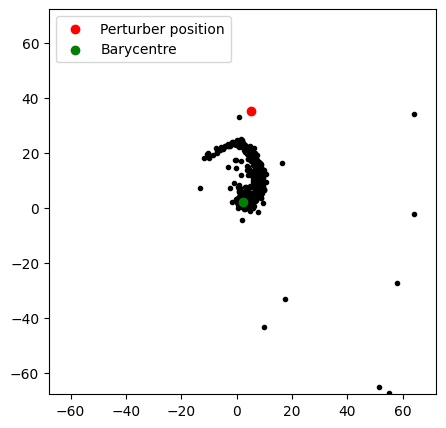

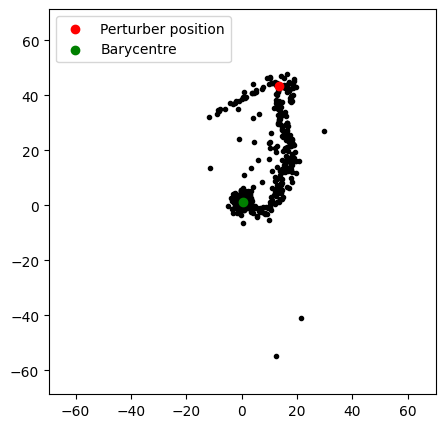

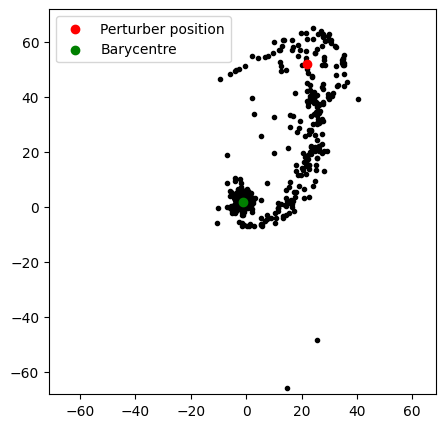

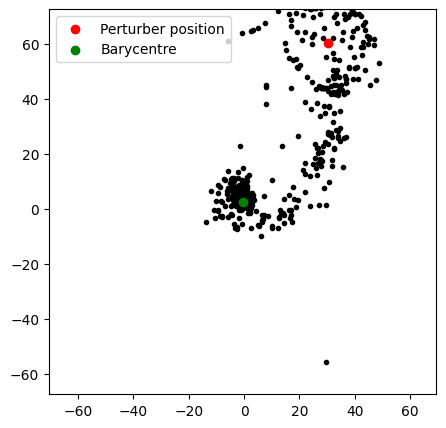

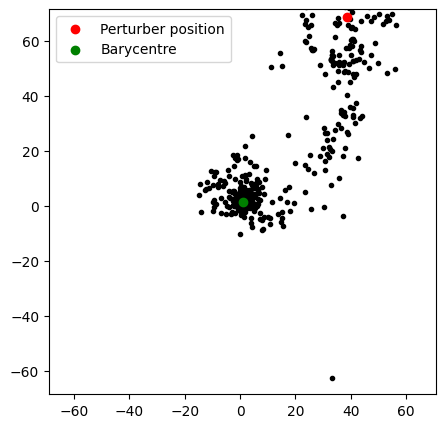

In [31]:
#slower encounter with a smaller perturber

mu = 2    #mass ratio of perturber to galaxy
V = 0.7    #ratio of perturber velocity to minimum star circular velocity

m_p = mu*p
v_p = V*v_min

initial =[-20,10]  #Set the initial position of the perturber

#Set the duration of the simulation to be triple the time taken for the perturber to reach its closest approach with the galaxy
T = 3*np.sqrt(initial[0]**2 + initial[1]**2)/v_p
print('Time scale of simulation is ', T)

a = T/n
print('Time step is ',a)

star_array, perturber, barycentre = all_stars(x,y,v_x,v_y,v_p, m,m_p,a, e, n, initial, r_max, True)

plotting(star_array,perturber,barycentre, n,8,140)


Time scale of simulation is  3.9514339305129704
Time step is  0.00019757169652564853


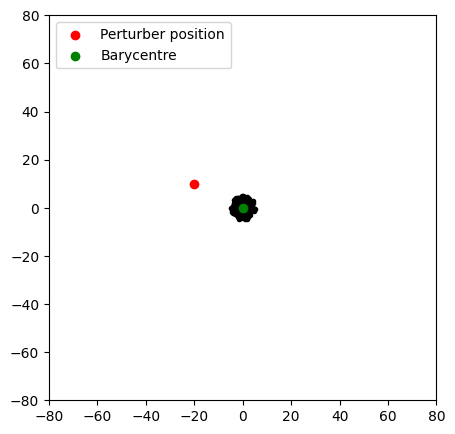

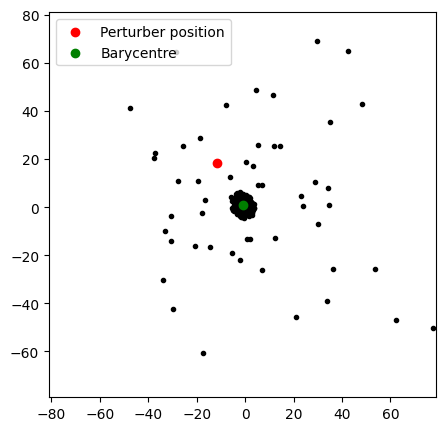

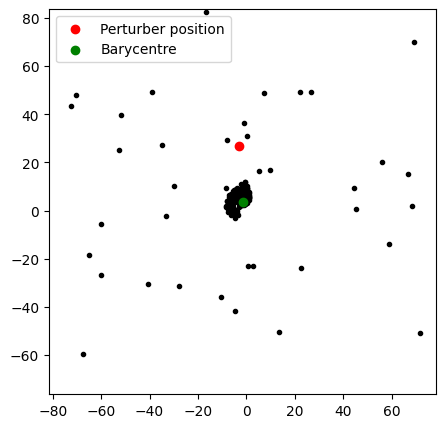

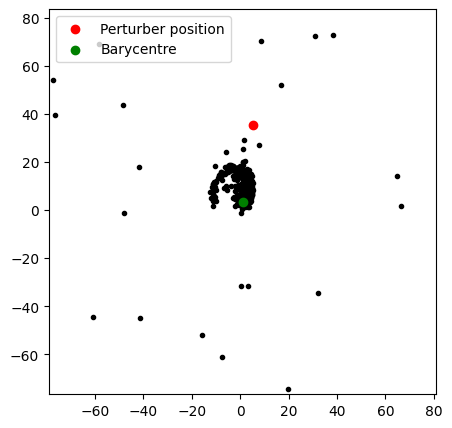

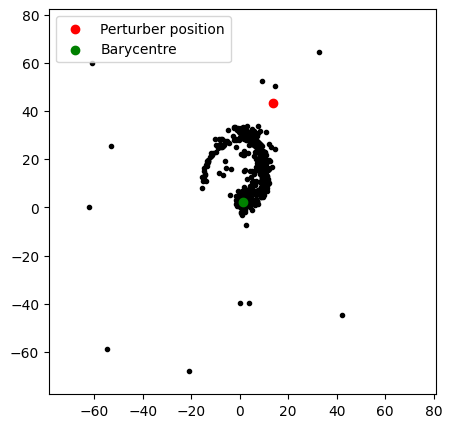

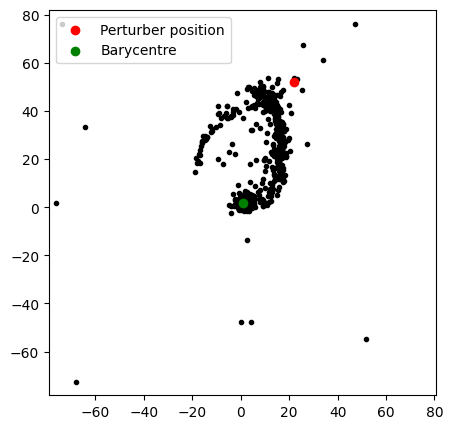

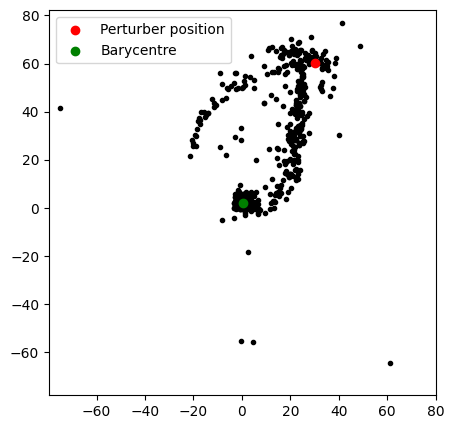

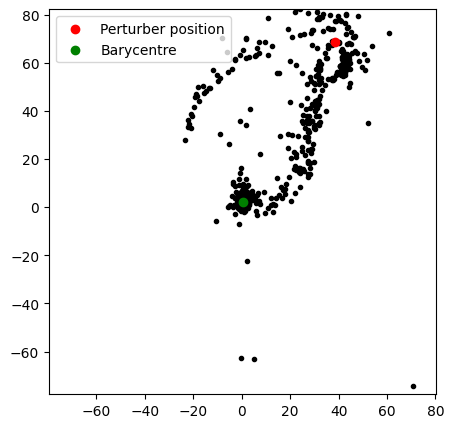

In [33]:
#faster encounter with a larger perturber

mu = 5    #mass ratio of perturber to galaxy
V = 1.2   #ratio of perturber velocity to minimum star circular velocity

m_p = mu*p
v_p = V*v_min

initial =[-20,10]  #Set the initial position of the perturber

#Set the duration of the simulation to be triple the time taken for the perturber to reach its closest approach with the galaxy
T = 3*np.sqrt(initial[0]**2 + initial[1]**2)/v_p
print('Time scale of simulation is ', T)

a = T/n
print('Time step is ',a)

star_array, perturber, barycentre = all_stars(x,y,v_x,v_y,v_p, m,m_p,a, e, n, initial, r_max, True)

plotting(star_array,perturber,barycentre, n,8,160)